# 提交多机多卡分布式训练任务 (TFJob方式)

本示例介绍使用提交 TFJob 的方法，运行本 Notebook 中的示例代码和应用可以完成启动2个 worker 每个 worker 使用1张 GPU 卡的 MNIST 分布式训练示例。


## 编写并执行分布式训练任务

1. 在 Notebook 中编写适用于分布式训练的代码。我们提供了样例代码：`dist_mnist_keras_nccl.py`。
2. 编写 TFJob 分布式训练任务提交的 YAML 配置：我们提供了样例配置：`dist_mnist.yaml`，其中：
    - `image`: 运行当前任务使用的镜像，没有额外需求可以直接使用官方镜像比如 `tensorflow/tensorflow:2.5.1-gpu`
    - `command`: 启动分布式训练任务的命令
    - `volumnes`: 可以直接挂载当前 Notebook 的 PVC，这样在 Notebook 中开发测试的程序可以直接提交分布式训练。修改 `claimName` 为您当前的 Notebook PVC，可以从以下界面查看、新增

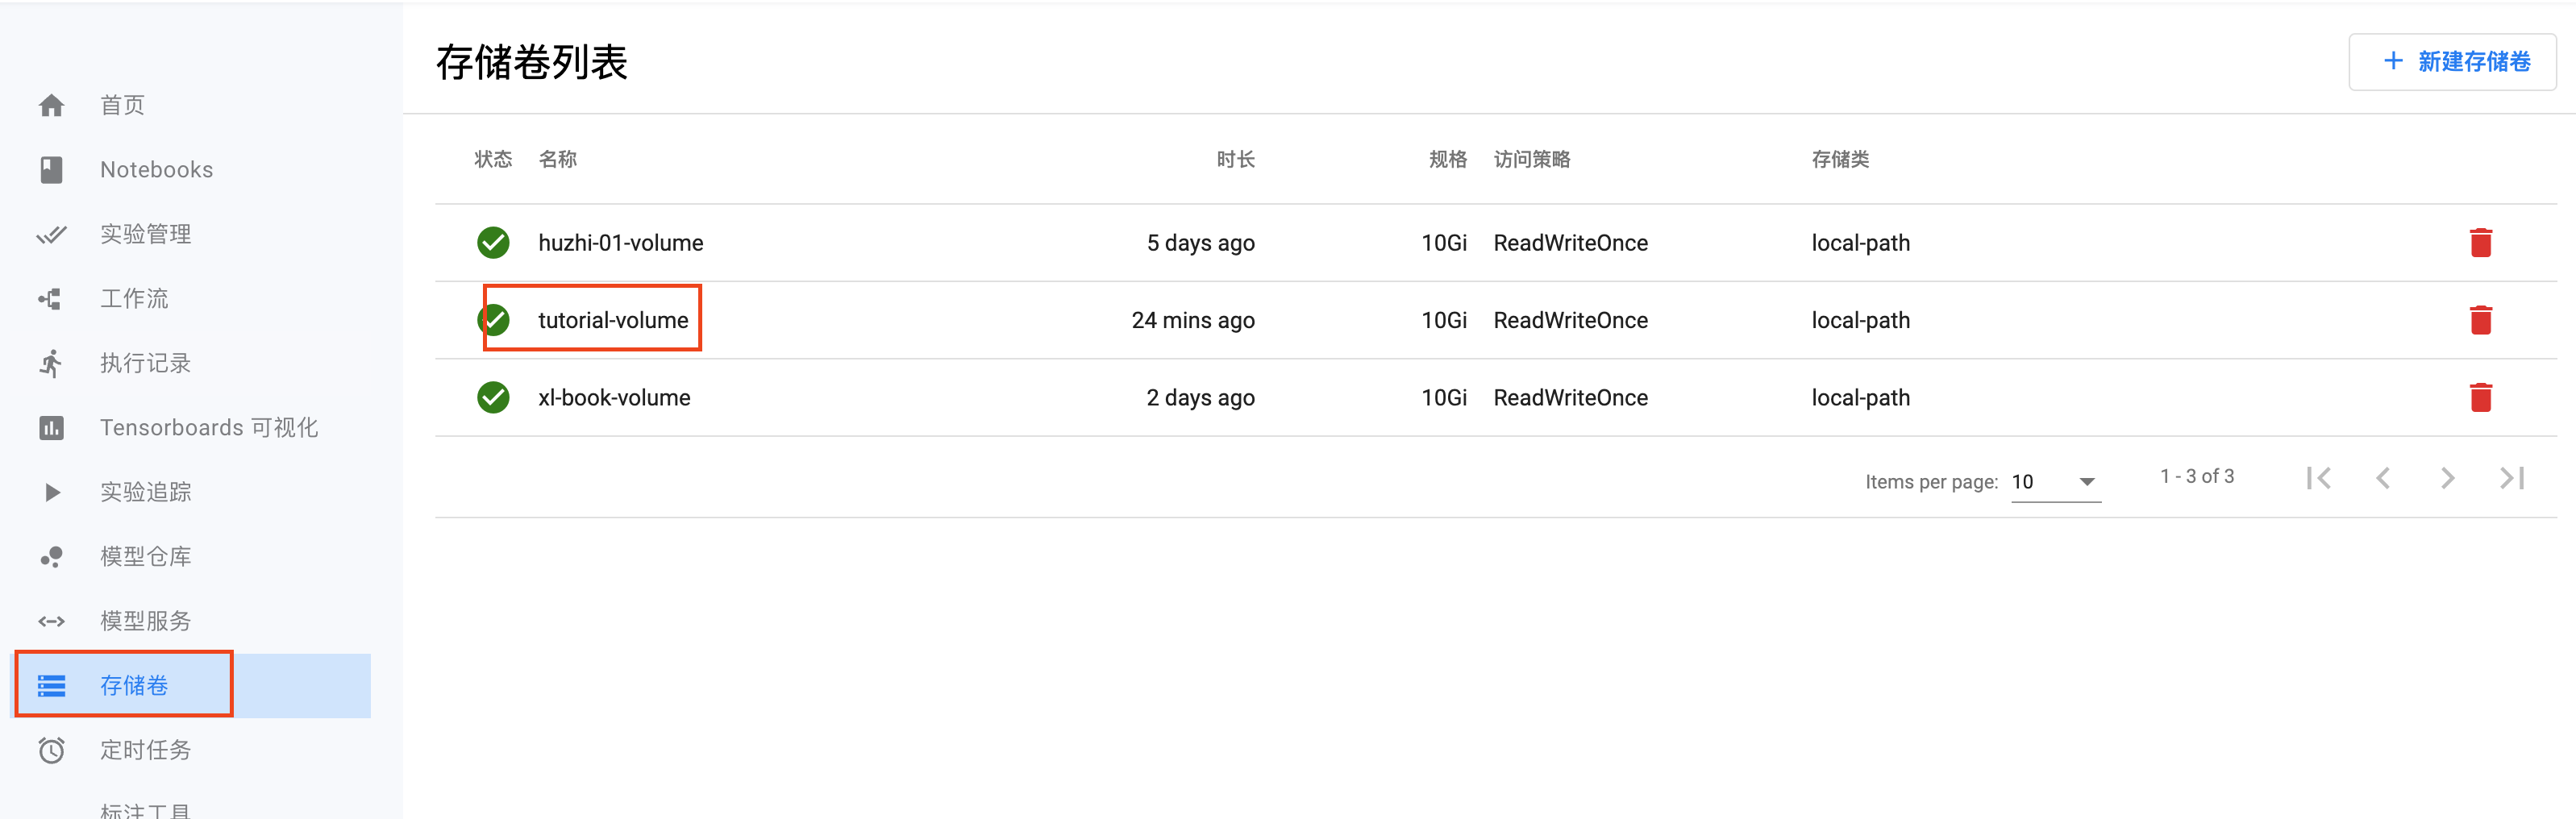

```yaml
apiVersion: kubeflow.org/v1
kind: TFJob
metadata:
  name: multi-worker-mnist-nccl
spec:
  runPolicy:
    cleanPodPolicy: None
  tfReplicaSpecs:
    Worker:
      # replicas: 启动 worker 的个数
      replicas: 2
      restartPolicy: Never
      template:
        spec:
          containers:
            - name: tensorflow
              # 设定分布式任务运行的镜像，可以使用官方镜像也可以使用自定义镜像
              image: build-harbor.alauda.cn/3rdparty/kubeflow/elyra-runtime-tensorflow:2.5.0
              # image: build-harbor.alauda.cn/3rdparty/kubeflow/elyra-runtime-intel-tensorflow:2.5.0
              # 设定任务启动的命令和参数。注意 "/train/" 目录是由 `volumeMounts` 决定的。在实际使用中
              # 确保使用可以通过网络挂载的 PVC，比如 NFS, Ceph 等，使得分布式训练 Pod 调度在不同节点也可以访问相同目录。
              command:
                - python
                - /train/src/dist_mnist_keras_nccl.py
                - --saved_model_dir
                - /train/saved_model/
                - --checkpoint_dir
                - /train/checkpoint
              # 设置 PVC 挂载到目录 `/train`
              volumeMounts:
                - mountPath: /train
                  name: training
              resources:
                # 设置每个 worker 的资源，包括 CPU/内存/GPU
                limits:
                  cpu: 2
                  memory: "2Gi"
                  # 配置 GPU 资源 （每个 worker 的 GPU 卡数，或者使用tencent.com/vcuda-core, tencent.com/vcuda-memory配置 vGPU 资源）
                  # nvidia.com/gpu: 1
                  # tencent.com/vcuda-core: 50
                  # tencent.com/vcuda-core: 30
          volumes:
            - name: training
              persistentVolumeClaim:
                # 设置需要挂载 PVC 名称，可以通过上述界面中查看或新增 （配置错误可能导致任务启动失败）
                claimName: wuyienv-volume
```

## 提交并运行

执行下面的命令提交任务，并等待任务执行完成。执行完成后，就可以使用当前 Notebook 目录下的 `saved_model` 目录下的模型。

In [2]:
!kubectl apply -f src/dist_mnist.yaml
!kubectl get tfjob

tfjob.kubeflow.org/multi-worker-mnist-nccl created
NAME                      STATE   AGE
multi-worker-mnist-nccl           0s


## 查看任务状态、日志

执行下面命令查看 tfjob 的 Pod 并获得每个 Pod 的运行日志。

In [11]:
!kubectl get pods | grep multi-worker-mnist-nccl

multi-worker-mnist-nccl-worker-0                   0/1     Completed            0          6m54s
multi-worker-mnist-nccl-worker-1                   0/1     Completed            0          6m54s



观察到如：
```
multi-worker-mnist-nccl-worker-0                                 0/1     Completed   0          25m
multi-worker-mnist-nccl-worker-1                                 0/1     Completed   0          25m
```
其中任务状态：

- “Completed” 表示分布式任务已经执行成功
- “Pending”表示任务在等待
- “Running”表示运行中
- “Error”表示运行存在错误。

查看每个 Worker (Pod) 的日志可以使用下面的命令，指定其中一个 Pod 查看日志：

In [12]:
!kubectl logs multi-worker-mnist-nccl-worker-0 --tail=10

Learning rate for epoch 8 is 9.999999747378752e-06
Epoch 9/10
70/70 [==============================] - 6s 93ms/step - loss: 0.0816 - accuracy: 0.9756

Learning rate for epoch 9 is 9.999999747378752e-06
Epoch 10/10
70/70 [==============================] - 6s 83ms/step - loss: 0.0854 - accuracy: 0.9751
2022-10-21 08:23:14.306160: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.

Learning rate for epoch 10 is 9.999999747378752e-06


## 删除任务

可以执行下面的命令删除任务记录：

In [33]:
!kubectl delete tfjob multi-worker-mnist-nccl

tfjob.kubeflow.org "multi-worker-mnist-nccl" deleted


## 使用 Gang-scheduling 调度器


如下在配置任务 YAML 文件时，在 `tfReplicaSpecs.<type>.template.spec` 下配置 `schedulerName: volcano` 即可配置任务使用 volcano 调度器。
这样每个任务只有在所有 Worker 资源之和都足够时才会开始运行，并可以配置队列/优先级/调度算法插件等满足训练任务调度中的各种需求。

```yaml
apiVersion: kubeflow.org/v1
kind: TFJob
metadata:
  name: multi-worker-mnist-nccl
spec:
  runPolicy:
    cleanPodPolicy: None
  tfReplicaSpecs:
    Worker:
      replicas: 2
      restartPolicy: Never
      template:
        spec:
          # 在这里配置 `schedulerName: volcano` 既可配置任务使用 gang scheduler
          schedulerName: volcano
          containers:
            - name: tensorflow
              image: tensorflow/tensorflow:2.5.1-gpu
              command:
                - python
                - /train/samples/dist_mnist_keras_nccl.py
                - --saved_model_dir
                - /train/saved_model/
                - --checkpoint_dir
                - /train/checkpoint
              volumeMounts:
                - mountPath: /train
                  name: training
              resources:
                limits:
                  cpu: 2
                  memory: "4Gi"
                  # 配置 GPU 资源 （每个 worker 的 GPU 卡数，或者使用tencent.com/vcuda-core, tencent.com/vcuda-memory配置 vGPU 资源）
                  # nvidia.com/gpu: 1
          volumes:
            - name: training
              persistentVolumeClaim:
                claimName: wuyi-notebook1-volume
```

在 Notebook 创建之后 `/samples` 目录下，我们默认提供了 `dist_mnist_schedule_test.yaml` 示例使用 Gang-Scheduling 时，5个任务资源调度的情况。我们在 2节点 x 16c32G 机器测试。在未安装 volcano 调度器时，因为默认是按照 Pod 调度不是按照 Job 调度，5个任务同时启动之后，有些 Pod 就会先占用资源，导致有的任务有一部分 Pod 分配到资源，另一部分还在等待资源时，集群的资源就分配完了，就进入了永恒的等待。在启用 Gang-Scheduling 后，资源会按照整个 Job 调度，不会出现 Pod 空跑的情况。

您可以使用下面命令提交5个任务，验证 Gang-Scheduling 调度：

In [ ]:
!kubectl apply -f dist_mnist_schedule_test.yaml